In [38]:
import struct
import dataProcess
import numpy as np
import PIL
import matplotlib.pyplot as plt
import multiprocessing as mp
import seaborn as sns
import pandas as pd
import cv2
import gc
cv2.__version__

%matplotlib inline

train_data_dir = "HWDB1.1trn_gnt"
test_data_dir = "HWDB1.1tst_gnt"

In [2]:
images = []
labels = []
#X_test = []
#y_test =[]

for image, tagcode in dataProcess.read_from_gnt_dir(train_data_dir):
    tagcode_unicode = struct.pack('>H', tagcode).decode('gb2312')
    images.append(image)
    labels.append(tagcode_unicode)
    
#pool2 = mp.Pool()

"""
for image, tagcode in dataProcess.read_from_gnt_dir(test_data_dir):
    tagcode_unicode = struct.pack('>H', tagcode).decode('gb2312')
    test_counter += 1
    X_test.append(image)
    y_test.append(tagcode_unicode)
 

"""

"\nfor image, tagcode in dataProcess.read_from_gnt_dir(test_data_dir):\n    tagcode_unicode = struct.pack('>H', tagcode).decode('gb2312')\n    test_counter += 1\n    X_test.append(image)\n    y_test.append(tagcode_unicode)\n \n\n"

In [3]:
%xdel tagcode
%xdel image
gc.collect()
gc.collect()
gc.collect()

0

In [4]:
images = np.array(images)
labels = np.array(labels)

In [5]:
print(images[0].shape)
print(np.unique(labels).shape)

(76, 66)
(3755,)


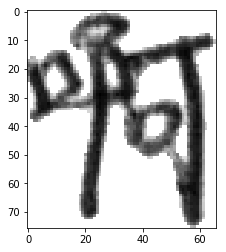

In [6]:
plt.imshow(images[0], cmap='gray')

## 绘制“笔画-$\sqrt{像素}$     ”图形
### 查询每个label的笔画
`bihua.txt`记录了所有unicode汉字的笔画信息

In [7]:
book = open('bihua.txt').readlines()
bihua_dict = {}
for line in book:
    words = line.strip().split()
    bihua_dict[words[0]] = int(words[1])
print(bihua_dict['木'])
labels_bihua = [bihua_dict[y] for y in labels]

4


### 计算$\sqrt{像素点}$

In [16]:
images_pn = [np.sqrt(img.shape[0] * img.shape[1]) for img in images]

将数据放入类DataFrame中

In [17]:
df = pd.DataFrame({'idx':[i for i in range(images.shape[0])],
                  'bihua':labels_bihua,
                  'pixels_num':images_pn}) 
df = df.sort_values(by=['bihua'])

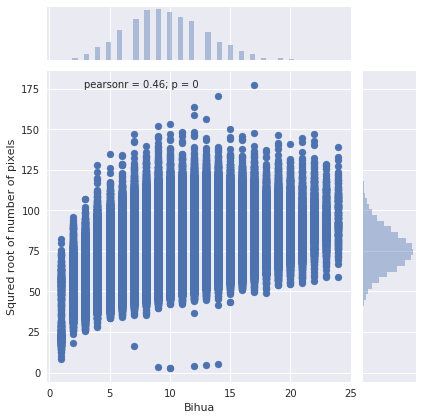

In [18]:
sns.set()

g = sns.jointplot(x="bihua", y="pixels_num", data=df)
g.set_axis_labels("Bihua", "Squred root of number of pixels");
g.savefig("bihua_sp.png")
plt.show()

In [19]:
%xdel df
%xdel g
%xdel images_pn
gc.collect()
gc.collect()
gc.collect()

0

## 使用One-class SVM with RBF检测outliers
数据太大，跑了一个多小时不出结果，放弃。我大概看了许多，极端数据和错误分类应该没有想象的那么可怕，所以暂时用阈值吧。

In [ ]:
from sklearn import svm
df_od = df[['pixels_num', 'bihua']].values

clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
clf.fit(df_od)
y_pred = clf.predict(df_od)
print(len(y_pred))

## 使用阈值过滤尺寸小的图片
调参：

6 15
腰


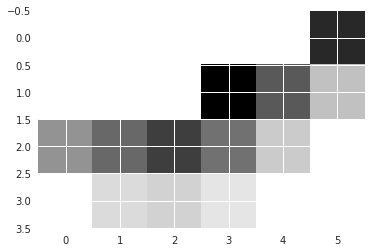

In [20]:
min_h = 999
min_w = 999
img_min = []
i = 0
for idx,img in enumerate(images): 
    i+=1
    if img.shape[0] <= 25 and img.shape[1] <= 25:
        img_min = img
        y_min = labels[i-1]
        continue
    min_h = min_h if img.shape[0]>min_h else img.shape[0]
    min_w = min_w if img.shape[1]>min_w else img.shape[1]
print(min_h, min_w)
print(y_min)
plt.imshow(img_min, cmap='gray')

In [7]:
images_filtered = []
labels_filtered = []
for i,img in enumerate(images): 
    if img.shape[0] > 25 or img.shape[1] > 25:
        images_filtered.append(img)
        labels_filtered.append(labels[i])
images_filtered = np.array(images_filtered)
labels_filtered = np.array(labels_filtered)
print(images_filtered.shape, labels_filtered.shape)

(897747,) (897747,)


In [8]:
%xdel images
gc.collect()
gc.collect()
gc.collect()

0

In [9]:
%whos

Variable          Type       Data/Info
--------------------------------------
PIL               module     <module 'PIL' from '/home<...>ackages/PIL/__init__.py'>
cv2               module     <module 'cv2' from '/home<...>.5/site-packages/cv2.so'>
dataProcess       module     <module 'dataProcess' fro<...>-2018/CV/dataProcess.py'>
gc                module     <module 'gc' (built-in)>
i                 int        897757
images_filtered   ndarray    897747: 897747 elems, type `object`, 7181976 bytes (6.849266052246094 Mb)
img               ndarray    183x99: 18117 elems, type `uint8`, 18117 bytes
labels            ndarray    897758: 897758 elems, type `<U1`, 3591032 bytes (3.4246749877929688 Mb)
labels_filtered   ndarray    897747: 897747 elems, type `<U1`, 3590988 bytes (3.424633026123047 Mb)
mp                module     <module 'multiprocessing'<...>iprocessing/__init__.py'>
np                module     <module 'numpy' from '/ho<...>kages/numpy/__init__.py'>
pd                module   

训练只取其width或者height大于25的,这种方法能过滤11个样本

## Padding with 255
scipy的imresize移到了skimage，skimage不能处理灰度图像，还要转换一次。。。只能用OpenCV了。

In [29]:
from skimage import data, color
from skimage.transform import resize

def impad(img, full_shape=(128,128)):
    (fh, fw) = full_shape
    (h, w) = img.shape
    if h >= w:
        img = cv2.resize(img, (int(w*(fh/h)), fh))
        (h, w) = img.shape
    else:
        img = cv2.resize(img, (fw, int(h*(fw/w))) )
        (h, w) = img.shape
    
    x = 0 if fh-h<=0 else np.random.randint(0,fh-h)
    y = 0 if fw-w<=0 else np.random.randint(0,fw-w)
    
    result = np.full(full_shape,255)
    result[x:img.shape[0]+x,y:img.shape[1]+y] = img
    return result.reshape(fh,fw,1)


吐


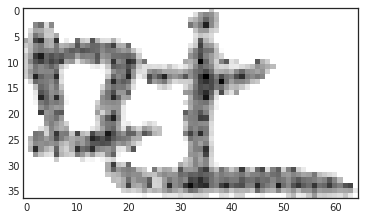

In [34]:
sns.set_style("white")
print(labels_filtered[80001])
plt.imshow(images_filtered[80001], cmap='gray')

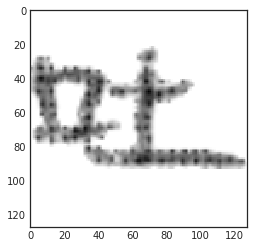

In [37]:
padded_img = impad(images_filtered[80001], full_shape=(128,128))
plt.imshow(padded_img.reshape((128,128)), cmap='gray')

## Checkpoint
let's rock'n roll!

In [1]:
import keras

/home/meirtz/envs/dl/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from keras import utils#.to_categorical
from keras.preprocessing.image import ImageDataGenerator
import struct
import dataProcess
import numpy as np
import PIL
import matplotlib.pyplot as plt
import multiprocessing as mp
import seaborn as sns
import pandas as pd
import cv2
import gc
import os
import glob
from tqdm import *
from sklearn import preprocessing


%matplotlib inline

In [3]:
import pickle
class DataGenerator:
    def __init__(self, dim_x = 128, dim_y = 128, batch_size = 128, shuffle = True):
        'Initialization: x -> height, y -> width'
        self.dim_x = dim_x
        self.dim_y = dim_y
        self.batch_size = batch_size
        self.shuffle = shuffle
        
        def load_obj(name ):
            with open('obj/' + name + '.pkl', 'rb') as f:
                return pickle.load(f)
        self.labels_to_idx = load_obj('labels_to_idx')
        self.lb = preprocessing.LabelBinarizer()
        self.int_labels = list(self.labels_to_idx.values())
        self.lb.fit(self.int_labels)
        
    def __get_exploration_order(self, list_IDs):
        'Generates order of exploration'
        # Find exploration order
        indexes = np.arange(len(list_IDs))
        if self.shuffle == True:
            np.random.shuffle(indexes)
        return indexes
    
    def __data_generation(self, labels_temp, list_IDs_temp):
        'Generates data of batch_size samples' # X : (n_samples, v_size, v_size, n_channels)
        # Initialization
        X = np.empty((self.batch_size, self.dim_x, self.dim_y, 1))
        y = np.empty((self.batch_size), dtype = int)

        # Generate data
        for i, filename in enumerate(list_IDs_temp):
            # Store volume
            X[i, :, :, 0] = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

            # Store class
            y[i] = self.labels_to_idx[labels_temp[i]]

        return X, self.lb.transform(y)
    
    def generate(self, labels, list_IDs):
        'Generates batches of samples'
        # Infinite loop
        while 1:
            # Generate order of exploration of dataset
            indexes = self.__get_exploration_order(list_IDs)

            # Generate batches
            imax = int(len(indexes)/self.batch_size)
            for i in range(imax):
                # Find list of IDs
                list_IDs_temp = [list_IDs[k] for k in indexes[i*self.batch_size:(i+1)*self.batch_size]]
                labels_temp = [labels[k] for k in indexes[i*self.batch_size:(i+1)*self.batch_size]]
                # Generate data
                X, y = self.__data_generation(labels_temp, list_IDs_temp)

                yield X, y
                

In [4]:
filenames = glob.glob('train/*.png')
labels = [filename.split('/')[1].split('-')[1].split('.')[0] for filename in filenames]

897352 核


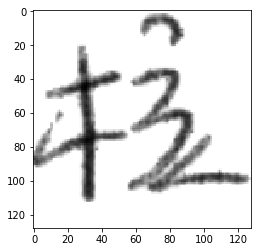

In [5]:
print(len(filenames), labels[800000])
#test_img = plt.imread(filenames[800000])
test_img = cv2.imread(filenames[800000], cv2.IMREAD_GRAYSCALE)
plt.imshow(test_img, cmap='gray')

In [6]:
from sklearn.model_selection import train_test_split
batch_size = 256
input_shape = (128,128,1)
num_classes = len(np.unique(labels))
epochs = 18

In [7]:

params = {'dim_x': 128,
          'dim_y': 128,
          'batch_size': batch_size,
          'shuffle': False}
X_train, X_valid, y_train, y_valid = train_test_split(filenames, labels, test_size=0.2)
training_generator = DataGenerator(**params).generate(y_train, X_train)
validation_generator = DataGenerator(**params).generate(y_valid, X_valid)

train_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
        'train/',
        target_size=(128, 128),
        batch_size=batch_size,
        color_mode="grayscale")

用垃圾模型测试。这个垃圾模型能让我的1080使用率跑到65-90%

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=input_shape))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [ ]:
model.fit_generator(generator = training_generator,
                    steps_per_epoch = len(y_train)//batch_size,
                    validation_data = validation_generator,
                    validation_steps = len(y_valid)//batch_size,
                    epochs=epochs,
                    shuffle=False)

Epoch 1/18
2804/2804 [==============================] - 1090s 389ms/step - loss: 16.1137 - acc: 2.7026e-04 - val_loss: 16.1141 - val_acc: 2.5076e-04
Epoch 2/18
2804/2804 [==============================] - 1088s 388ms/step - loss: 16.1137 - acc: 2.7165e-04 - val_loss: 16.1141 - val_acc: 2.5076e-04
Epoch 3/18
 552/2804 [====>.........................] - ETA: 13:30 - loss: 16.1143 - acc: 2.3353e-04

In [ ]:
#print(labels_to_idx_dict)

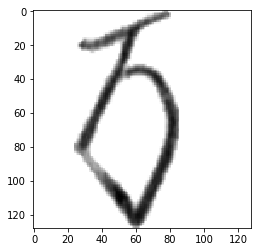

In [33]:
def load_obj(name ):
    with open('obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)
idx_to_labels = load_obj('idx_to_labels')
i = 1000
#test_img = cv2.imread(filenames[i], cv2.IMREAD_GRAYSCALE)
test_img = cv2.imread('train/3/2800.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(test_img, cmap='gray')
#print(labels[i])
result = model.predict(test_img.reshape(1,128,128,1))

In [35]:
#print(train_generator.class_indices)
print(idx_to_labels[np.argmax(result)])

狠
